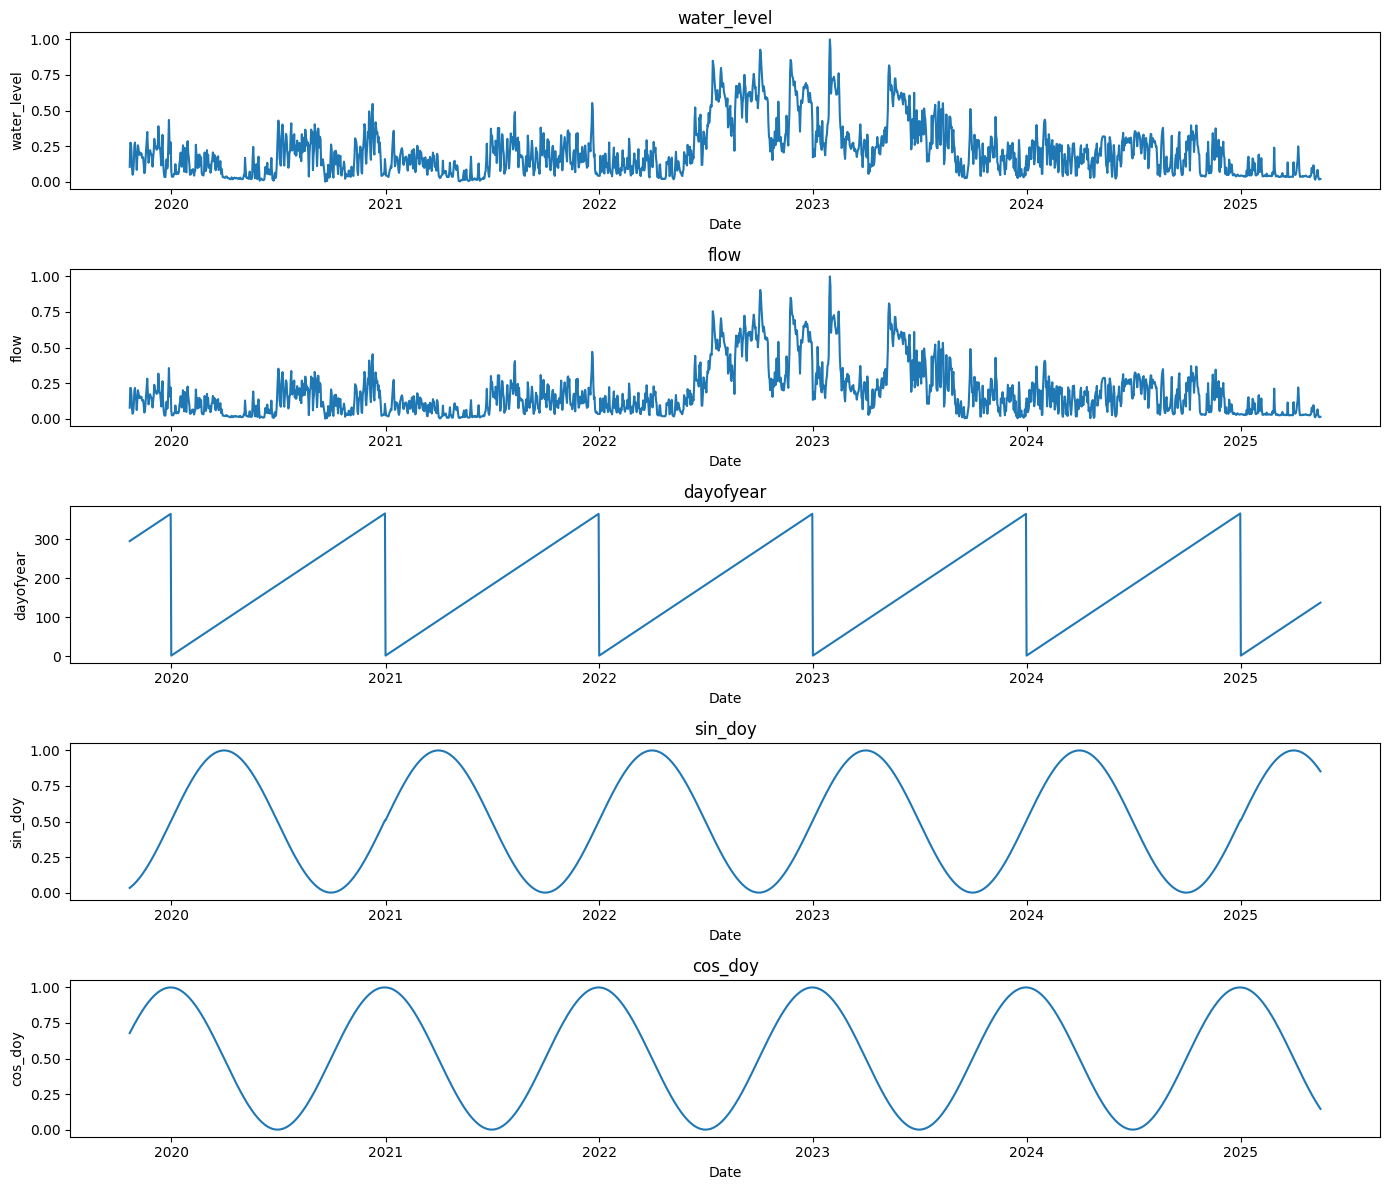

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Layer
from tensorflow.keras.models import Model, Sequential
import pennylane as qml
import pennylane.numpy as pnp

df = pd.read_csv('data/Hamilton.csv', skiprows=1)

df = df[pd.to_datetime(df['date'], errors='coerce').notnull()].reset_index(drop=True)

df = df.drop(columns=['time'])

df = df.rename(columns={'wlvalue': 'water_level', 'flvalue': 'flow'})

df['date'] = pd.to_datetime(df['date'])

df['dayofyear'] = df['date'].dt.dayofyear
df['sin_doy'] = np.sin(2*np.pi*df['dayofyear']/365)
df['cos_doy'] = np.cos(2*np.pi*df['dayofyear']/365)
features = ['water_level', 'flow', 'sin_doy', 'cos_doy']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

cols_to_plot = ['water_level', 'flow', 'dayofyear', 'sin_doy', 'cos_doy']

plt.figure(figsize=(14, 12))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df['date'], df[col])
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.tight_layout()

plt.show()

== Données brutes ==
        date  water_level      flow  dayofyear   sin_doy   cos_doy
0 2019-10-22     0.103742  0.076903        295  0.033077  0.678843
1 2019-10-23     0.274065  0.215944        296  0.036225  0.686854
2 2019-10-24     0.271226  0.214927        297  0.039510  0.694810
3 2019-10-25     0.213677  0.166361        298  0.042932  0.702707
4 2019-10-26     0.088774  0.065192        299  0.046489  0.710545
== Données brutes ==
        date  water_level     flow
0 2019-10-22       11.787  186.463
1 2019-10-23       12.447  252.889
2 2019-10-24       12.436  252.403
3 2019-10-25       12.213  229.201
4 2019-10-26       11.729  180.868
== Après PCA ==
        date  water_level     flow  hydro_pca
0 2019-10-22       11.787  186.463  -0.149628
1 2019-10-23       12.447  252.889   0.069475
2 2019-10-24       12.436  252.403   0.066726
3 2019-10-25       12.213  229.201  -0.008406
4 2019-10-26       11.729  180.868  -0.168530
== Après features saisonnières ==
        date  hydro_

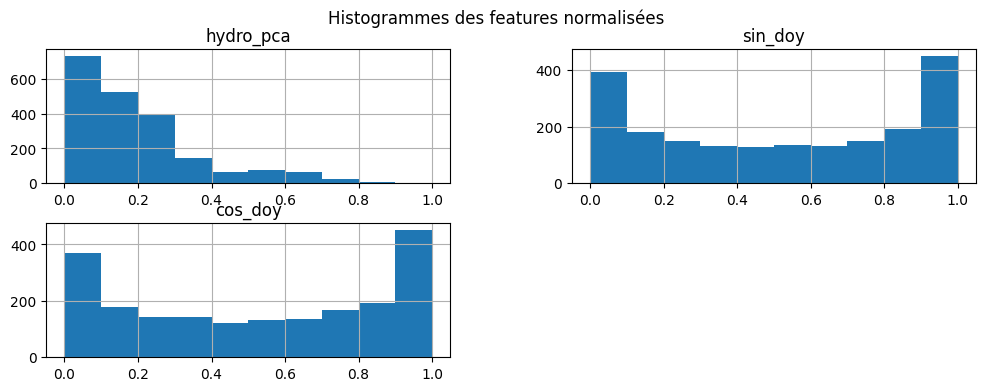

In [2]:
print("== Données brutes ==")
print(df.head())

df = pd.read_csv('data/Hamilton.csv', skiprows=1)
df = df[pd.to_datetime(df['date'], errors='coerce').notnull()].reset_index(drop=True)
df = df.drop(columns=['time'])
df = df.rename(columns={'wlvalue': 'water_level', 'flvalue': 'flow'})
df['date'] = pd.to_datetime(df['date'])

print("== Données brutes ==")
print(df.head())

# Normalisation préalable sur water_level/flow pour la PCA
scaler_hydro = MinMaxScaler()
hydro_norm = scaler_hydro.fit_transform(df[['water_level', 'flow']])

# PCA 1D (1 composante)
pca = PCA(n_components=1)
df['hydro_pca'] = pca.fit_transform(hydro_norm)

print("== Après PCA ==")
print(df[['date', 'water_level', 'flow', 'hydro_pca']].head())


# Ajout features saisonnières
df['dayofyear'] = df['date'].dt.dayofyear
df['sin_doy'] = np.sin(2*np.pi*df['dayofyear']/365)
df['cos_doy'] = np.cos(2*np.pi*df['dayofyear']/365)

print("== Après features saisonnières ==")
print(df[['date', 'hydro_pca', 'sin_doy', 'cos_doy']].head())

# Normalisation des features finales
scaler = MinMaxScaler()
features = ['hydro_pca', 'sin_doy', 'cos_doy']
df[features] = scaler.fit_transform(df[features])

print("== Après normalisation finale ==")
print(df[['date', 'hydro_pca', 'sin_doy', 'cos_doy']].head())

print("== Statistiques finales ==")
print(df[features].describe())


import matplotlib.pyplot as plt

df[features].hist(figsize=(12, 4))
plt.suptitle("Histogrammes des features normalisées")
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Layer
from tensorflow.keras.models import Model, Sequential
import pennylane as qml
from tensorflow.keras.layers import Concatenate
import pennylane.numpy as pnp

TF_ENABLE_ONEDNN_OPTS=0

print("\n=== 1. Chargement et nettoyage ===")
df = pd.read_csv('data/Hamilton.csv', skiprows=1)
print("Forme initiale du CSV :", df.shape)
print("Colonnes :", df.columns.tolist())
print(df.head())

df = df[pd.to_datetime(df['date'], errors='coerce').notnull()].reset_index(drop=True)
print("\nAprès suppression des lignes non-datées, shape :", df.shape)

df = df.drop(columns=['time'])
df = df.rename(columns={'wlvalue': 'water_level', 'flvalue': 'flow'})
df['date'] = pd.to_datetime(df['date'])
print("\nAprès renommage et nettoyage:")
print(df.head())
print(df.describe())
print("Types :\n", df.dtypes)

print("\n=== 2. Normalisation water_level/flow pour PCA ===")
scaler_hydro = MinMaxScaler()
hydro_norm = scaler_hydro.fit_transform(df[['water_level', 'flow']])
print("hydro_norm shape :", hydro_norm.shape)
print("hydro_norm (premières lignes) :\n", hydro_norm[:5, :])

pca = PCA(n_components=1)
df['hydro_pca'] = pca.fit_transform(hydro_norm)
print("\nPCA sur hydro, shape hydro_pca :", df['hydro_pca'].shape)
print("hydro_pca (head) :\n", df['hydro_pca'].head())

print("\n=== 3. Ajout features saisonnières ===")
df['dayofyear'] = df['date'].dt.dayofyear
df['sin_doy'] = np.sin(2*np.pi*df['dayofyear']/365)
df['cos_doy'] = np.cos(2*np.pi*df['dayofyear']/365)
print(df[['date', 'dayofyear', 'sin_doy', 'cos_doy']].head())

print("\n=== 4. Normalisation des features finales ===")
features = ['hydro_pca', 'sin_doy', 'cos_doy']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
print("df[features].describe() :\n", df[features].describe())
print(df[features].head())

print("\n=== 5. Sliding Windows ===")
WINDOW = 7
X, y = [], []
for i in range(WINDOW, len(df)-1):
    X.append(df[features].iloc[i-WINDOW:i].values) # shape (7,3)
    y.append(df['water_level'].iloc[i+1]) # Target: vrai water level (non normalisé)
X, y = np.array(X), np.array(y)
print("X shape :", X.shape)  # (nb_samples, 7, 3)
print("y shape :", y.shape)
print("X[0] :\n", X[0])
print("y[0] :", y[0])

print("\n=== 6. Split train/val/test ===")
N = len(X)
Ntrain = int(0.7*N)
Nval = int(0.15*N)
X_tr, X_val, X_te = X[:Ntrain], X[Ntrain:Ntrain+Nval], X[Ntrain+Nval:]
y_tr, y_val, y_te = y[:Ntrain], y[Ntrain:Ntrain+Nval], y[Ntrain+Nval:]
print("X_tr shape :", X_tr.shape)
print("X_val shape :", X_val.shape)
print("X_te shape :", X_te.shape)
print("y_tr shape :", y_tr.shape)

print("\n=== 7. Check scheduled_sampling ===")
def scheduled_sampling(X, y, model, prob=0.7):
    X_mod = X.copy()
    for i in range(min(2, X.shape[0])):  # print debug pour 2 sequences
        print(f"\nAvant scheduled_sampling X[{i}, :, 0] (hydro_pca):", X_mod[i, :, 0])
    for i in range(X.shape[0]):
        for t in range(1, X.shape[1]):
            if np.random.rand() > prob:
                pred = model.predict(X_mod[i:i+1], verbose=0)[0][0]
                X_mod[i, t, 0] = scaler.transform(pd.DataFrame([[pred, 0, 0]], columns=features))[0][0]
    for i in range(min(2, X.shape[0])):  # print debug pour 2 sequences
        print(f"Après scheduled_sampling X[{i}, :, 0] (hydro_pca):", X_mod[i, :, 0])
    return X_mod

print("\n=== 8. Modèle LSTM classique ===")
def build_lstm():
    model = Sequential([
        Input(shape=(WINDOW, len(features))),
        LSTM(32, return_sequences=False),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

print("Création du modèle LSTM...")
lstm = build_lstm()
print(lstm.summary())

print("\n=== 9. QRU LAYER (PENNYLANE) ===")
N_QUBITS = 3
N_LAYERS = 3  # re-uploading
dev = qml.device('default.qubit', wires=N_QUBITS)

def qru_circuit(x, weights):
    for day in range(WINDOW):
        for layer in range(N_LAYERS):
            for qubit in range(N_QUBITS):
                qml.RY(np.pi * x[day, qubit], wires=qubit)
                qml.RZ(weights[layer, qubit], wires=qubit)
    return [qml.expval(qml.PauliZ(wires=qubit)) for qubit in range(N_QUBITS)]

@qml.qnode(dev, interface='tf')
def qru_layer(x, weights):
    return qru_circuit(x, weights)

class QRULayer(Layer):
    def __init__(self, n_layers=N_LAYERS, n_qubits=N_QUBITS):
        super().__init__()
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.q_weights = self.add_weight(
            shape=(n_layers, n_qubits), initializer='uniform', trainable=True
        )
    def call(self, x):  # x shape: (batch, 7, 3)
        def run_qru(xx):
            res = qru_layer(xx, self.q_weights)
            tf.print("QRU res shape:", tf.shape(res), "val:", res)

            return tf.cast(tf.stack(res), tf.float32)
        return tf.map_fn(run_qru, x, fn_output_signature=tf.TensorSpec((N_QUBITS,), dtype=tf.float32)

)

print("\n=== 10. Modèle LSTM+QRU ===")
def build_lstm_qru():
    inp = Input(shape=(WINDOW, len(features)))
    lstm_out = LSTM(32, return_sequences=False)(inp)
    qru_out = QRULayer()(inp)
    print("Shape lstm_out:", lstm_out.shape)
    print("Shape qru_out:", qru_out.shape)
    x = Concatenate(axis=-1)([lstm_out, qru_out])
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

print("Création du modèle LSTM+QRU...")
lstm_qru = build_lstm_qru()
print(lstm_qru.summary())

print("\n=== 11. Entraînement et visualisation ===")
EPOCHS = 10
BATCH_SIZE = 32

def train_with_sampling(model, X, y, X_val, y_val, schedule_decay=0.03):
    losses, maes, val_losses, val_maes = [], [], [], []
    sampling_prob = 1.0
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}, scheduled_sampling_prob={sampling_prob:.3f}")
        X_mod = scheduled_sampling(X, y, model, prob=sampling_prob)
        #print("X_mod shape:", X_mod.shape)
        hist = model.fit(X_mod, y, epochs=1, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val))
        losses.append(hist.history['loss'][0])
        maes.append(hist.history['mae'][0])
        val_losses.append(hist.history['val_loss'][0])
        val_maes.append(hist.history['val_mae'][0])
        sampling_prob = max(0.0, sampling_prob - schedule_decay)
        print(f"Train loss: {losses[-1]:.4f}, Train MAE: {maes[-1]:.4f}, Val loss: {val_losses[-1]:.4f}, Val MAE: {val_maes[-1]:.4f}")
    return losses, maes, val_losses, val_maes

print("\n--- Entraînement LSTM classique ---")
losses_lstm, maes_lstm, vallosses_lstm, valmaes_lstm = train_with_sampling(lstm, X_tr, y_tr, X_val, y_val)

print("\n--- Entraînement LSTM+QRU ---")
losses_lstm_qru, maes_lstm_qru, vallosses_lstm_qru, valmaes_lstm_qru = train_with_sampling(lstm_qru, X_tr, y_tr, X_val, y_val)

print("\n=== 12. Visualisation ===")
plt.figure(figsize=(12,6))
plt.plot(losses_lstm, label='Train Loss LSTM')
plt.plot(vallosses_lstm, label='Val Loss LSTM')
plt.plot(losses_lstm_qru, label='Train Loss LSTM+QRU')
plt.plot(vallosses_lstm_qru, label='Val Loss LSTM+QRU')
plt.title('Courbes de loss par epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(maes_lstm, label='Train MAE LSTM')
plt.plot(valmaes_lstm, label='Val MAE LSTM')
plt.plot(maes_lstm_qru, label='Train MAE LSTM+QRU')
plt.plot(valmaes_lstm_qru, label='Val MAE LSTM+QRU')
plt.title('Courbes de MAE (accuracy proxy) par epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

y_pred_lstm = lstm.predict(X_te[-30:])
y_pred_qru = lstm_qru.predict(X_te[-30:])
dates_last = df['date'].iloc[-30:]

print("\n--- Données vraies (30 derniers jours):", y_te[-30:])
print("--- LSTM predictions:", y_pred_lstm.flatten())
print("--- LSTM+QRU predictions:", y_pred_qru.flatten())

plt.figure(figsize=(14,6))
plt.plot(dates_last, y_te[-30:], 'o-', label='Vraies valeurs')
plt.plot(dates_last, y_pred_lstm, 's--', label='LSTM')
plt.plot(dates_last, y_pred_qru, 'd--', label='LSTM+QRU')
plt.title('Comparaison vraie vs prédit (30 derniers jours)')
plt.xlabel('Date')
plt.ylabel('Niveau d\'eau (water_level)')
plt.legend()
plt.tight_layout()
plt.show()


=== 1. Chargement et nettoyage ===
Forme initiale du CSV : (2038, 4)
Colonnes : ['date', 'time', 'wlvalue', 'flvalue']
         date      time  wlvalue  flvalue
0  2019-10-22  01:00:00   11.787  186.463
1  2019-10-23  01:00:00   12.447  252.889
2  2019-10-24  01:00:00   12.436  252.403
3  2019-10-25  01:00:00   12.213  229.201
4  2019-10-26  01:00:00   11.729  180.868

Après suppression des lignes non-datées, shape : (2035, 4)

Après renommage et nettoyage:
        date  water_level     flow
0 2019-10-22       11.787  186.463
1 2019-10-23       12.447  252.889
2 2019-10-24       12.436  252.403
3 2019-10-25       12.213  229.201
4 2019-10-26       11.729  180.868
                      date  water_level         flow
count                 2035  2035.000000  2035.000000
mean   2022-08-04 00:00:00    12.206789   235.774300
min    2019-10-22 00:00:00    11.385000   149.723000
25%    2021-03-13 12:00:00    11.676000   174.886000
50%    2022-08-04 00:00:00    12.057000   213.686000
75%    20

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

None

=== 9. QRU LAYER (PENNYLANE) ===

=== 10. Modèle LSTM+QRU ===
Création du modèle LSTM+QRU...

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: (<gast.gast.NamedExpr object at 0x000001BDEF78D120>, (mcm_method := mcm_config.mcm_method))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: (<gast.gast.NamedExpr object at 0x000001BDEF78D120>, (mcm_method := mcm_config.mcm_method))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence thi

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 7, 3)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 32)                │           4,608 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ qru_layer (QRULayer)          │ (None, 3)                 │               9 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 35)                │               0 │ lstm_1[0][0],              │
│                               │                           │                 │ qru_layer[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              36 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,653 (18.18 KB)

 Trainable params: 4,653 (18.18 KB)

 Non-trainable params: 0 (0.00 B)

None

=== 11. Entraînement et visualisation ===

--- Entraînement LSTM classique ---

Epoch 1/10, scheduled_sampling_prob=1.000

Avant scheduled_sampling X[0, :, 0] (hydro_pca): [0.09055498 0.24550771 0.24356394 0.19042907 0.07718726 0.04136703
 0.05797532]

Avant scheduled_sampling X[1, :, 0] (hydro_pca): [0.24550771 0.24356394 0.19042907 0.07718726 0.04136703 0.05797532
 0.1120457 ]
Après scheduled_sampling X[0, :, 0] (hydro_pca): [0.09055498 0.24550771 0.24356394 0.19042907 0.07718726 0.04136703
 0.05797532]
Après scheduled_sampling X[1, :, 0] (hydro_pca): [0.24550771 0.24356394 0.19042907 0.07718726 0.04136703 0.05797532
 0.1120457 ]
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 142.8990 - mae: 11.9242 - val_loss: 91.3163 - val_mae: 9.5309
Train loss: 132.7917, Train MAE: 11.4815, Val loss: 91.3163, Val MAE: 9.5309

Epoch 2/10, scheduled_sampling_prob=0.970

Avant scheduled_sampling X[0, :, 0] (hydro_pca): [0.09055498 0.24550771 0.24356394 0.19042907 0.07718726 0.04136703
 0.0579